In [3]:
!pip install tabulate


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sc

from sklearn.linear_model import LinearRegression

np.random.seed(42)

In [19]:
df = pd.read_csv('data/Questionnaire to Benchmark Explainable AI Methods.csv')
df = df.drop('Timestamp', axis=1)
df.drop(index=1, inplace=True)

In [20]:
# NaN handling

df = df.fillna(df.median())
df.fillna(method='bfill', inplace=True)


In [21]:
original_column_names = df.columns


In [22]:
new_columns = [f'question {i}' for i in range(1,26)]
df.columns = new_columns
df.head(15)


,question 1,question 2,question 3,question 4,question 5,question 6,question 7,question 8,question 9,question 10,...,question 16,question 17,question 18,question 19,question 20,question 21,question 22,question 23,question 24,question 25
0,No,Bachelor,Other,0,No,2.0,5.0,2.0,4.0,1.0,...,2.0,3.0,1.0,1.0,1.0,1.0,4.0,2.0,4.0,5.0
2,No,Bachelor,Psychology,1,No,6.0,5.0,4.0,5.0,5.0,...,5.0,5.0,4.0,5.0,4.0,6.0,6.0,5.0,6.0,6.0
3,No,Bachelor,Psychology,0,No,5.0,5.0,7.0,5.0,3.0,...,2.0,1.0,1.0,4.0,1.0,6.0,7.0,7.0,3.0,5.0
4,No,Master,Economics/Business,0,Yes,2.0,3.0,3.0,3.0,3.0,...,4.0,5.0,4.0,6.0,4.0,4.0,7.0,6.0,5.0,6.0
5,No,Graduate,Engineering,0,No,6.0,5.0,7.0,7.0,6.0,...,1.0,1.0,1.0,1.0,1.0,7.0,7.0,7.0,7.0,7.0
6,No,Graduate,Humanities,0,No,6.0,6.0,6.0,6.0,6.0,...,6.0,2.0,5.0,3.0,2.0,6.0,7.0,7.0,5.5,7.0
7,No,Other,Natural Sciences,0,No,5.0,6.0,4.0,5.0,4.0,...,2.0,1.0,2.0,1.0,1.0,6.0,7.0,6.0,7.0,6.0
8,No,Other,Natural Sciences,0,No,4.0,5.0,5.0,3.0,5.0,...,6.0,5.0,6.0,5.0,6.0,4.0,4.0,3.0,3.0,4.0
9,No,Master,Law,0,No,6.0,6.0,4.0,6.0,5.0,...,1.0,1.0,3.0,1.0,1.0,6.0,6.0,5.0,6.0,6.0
10,No,Bachelor,Engineering,0,No,4.0,3.0,4.0,2.0,3.0,...,7.0,6.0,7.0,6.0,7.0,7.0,7.0,7.0,7.0,7.0


In [9]:
ml_background = df[df['question 4'] >= '2']
non_ml_background = df.drop(index=ml_background.index)
ml_background.shape, non_ml_background.shape

((24, 25), (31, 25))

To split the groups according to question 3 use the following code
Question 3 asks for the major of the participants.

```
ml_background = df[df['question 3'] I= 'AI']
ml_background = ml_background.append(df[df['question 3'] == 'Data Science'])
non_ml_background = df.drop(index=ml_background.index)
ml_background.shape, non_ml_background.shape
```

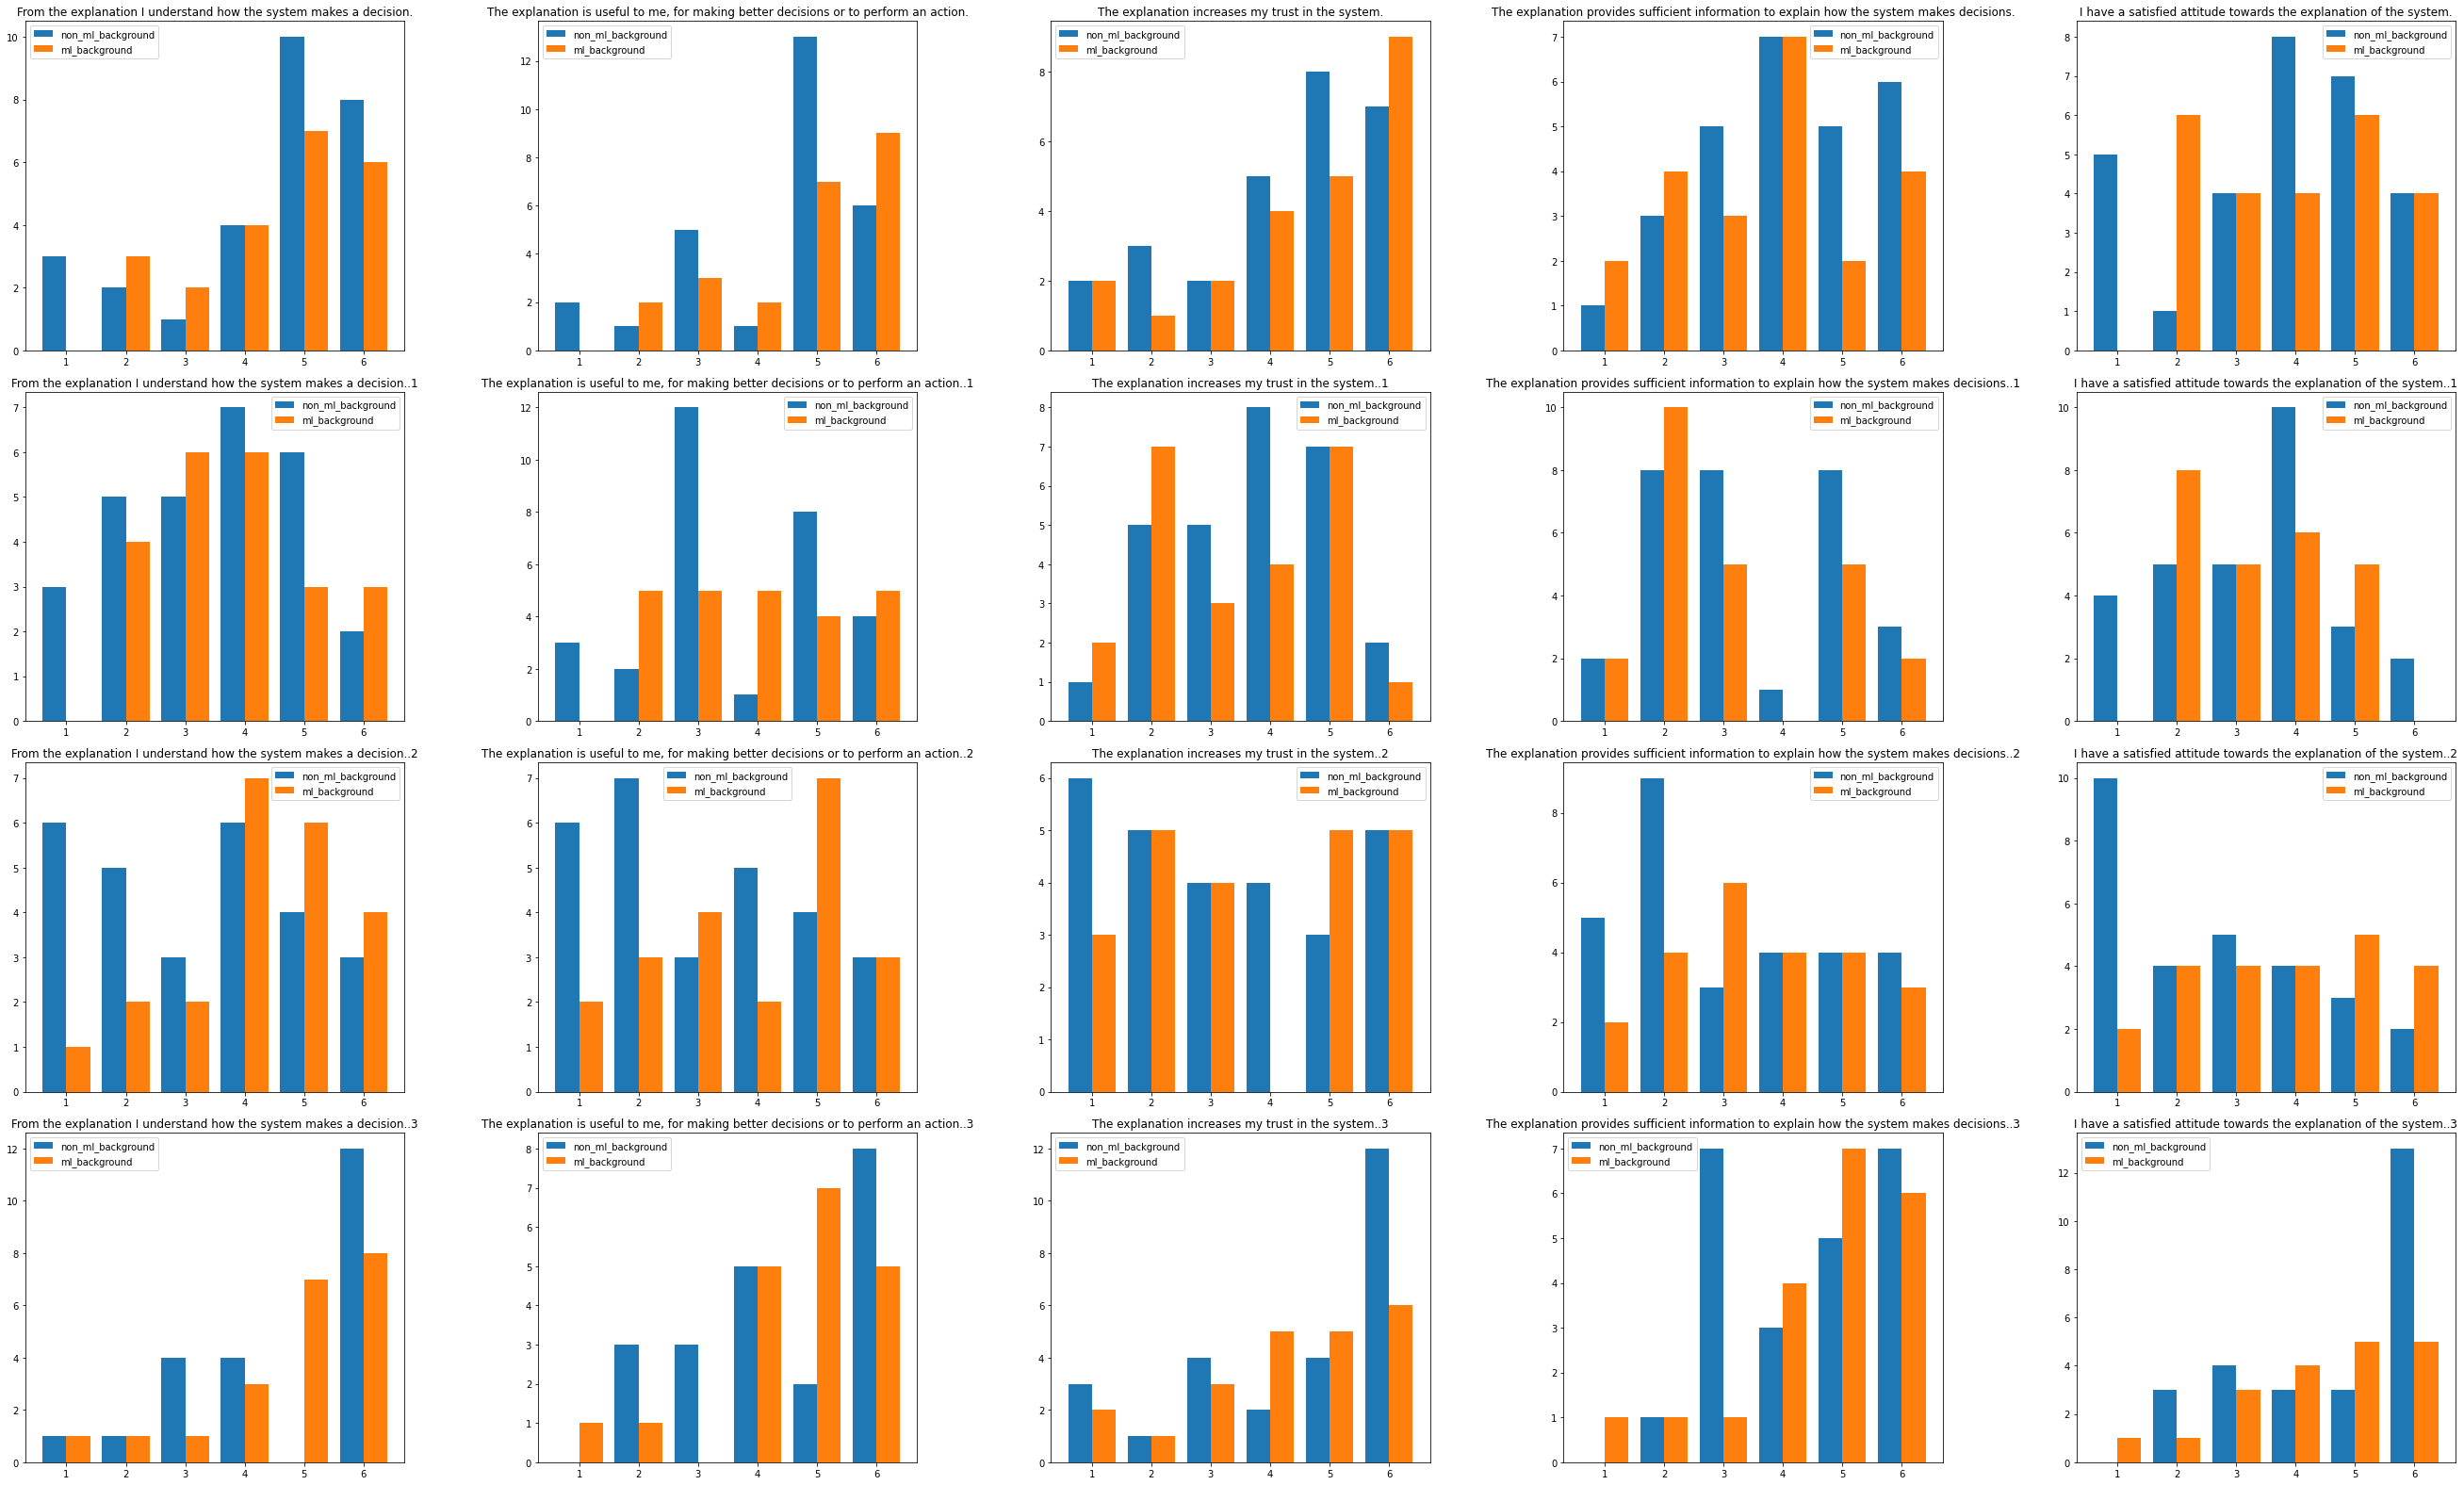

In [10]:
def get_histo_grid(safe_fig=False):
    """
    This function creates a histogram for each question.
    The data is segmented based on ML-Background
    @param safe_fig: defines if the figure is saved as .png
    @return: None
    """
    fig, axs = plt.subplots(4,5)
    fig.set_size_inches(37, 22)

    for i in range(6,26):
        data = [non_ml_background[f'question {i}'], ml_background[f'question {i}']]
        row = (i-6)//5
        col = (i-6)%5
        # axs[row,col].set_size_inches(18.5, 10.5)
        axs[row,col].hist(data, bins=np.arange(1,8)-0.5, histtype='bar',  label=['non_ml_background', 'ml_background'])
        axs[row,col].set_title(original_column_names[i-1])
        axs[row,col].legend()
    # plt.legend()
    plt.tight_layout()
    if safe_fig:
        plt.savefig('data/images/histo_grid')

get_histo_grid(safe_fig=True)


# some regressions



In [11]:

def get_regression_coeff(att_1=None, att_2=None):
    """
    This function returns all linear regression coefficients.
    if att_1 and att_2 are specified 1 regression coefficient is returned
    @param att_1: column index you want to regress from
    @param att_2: column index you want to regress to
    @return: one or all regression coefficients
    """
    if att_1 == None and att_2 == None:
        coeffs = np.zeros((20,20))
        for i in range(5,25):
            for j in range(5,25):
                X = df.iloc[:,i].values.reshape(-1,1)
                Y = df.iloc[:,j].values.reshape(-1,1)

                lin_reg = LinearRegression()
                lin_reg.fit(X,Y)
                coeffs[i-6,j-6] = lin_reg.coef_

        return coeffs
    else:
        X = df.iloc[:,att_1].values.reshape(-1,1)
        Y = df.iloc[:,att_2].values.reshape(-1,1)
        lin_reg = LinearRegression()
        lin_reg.fit(X,Y)

        return lin_reg.coef_
# get_regression_coeff()




In [12]:
def get_advanced_correlation_info():
    """
    Calculates Perarson correlation and student-t-test for every pair of features.
    the third axis is used to differenciate between test, stats-value and p-value
    @return: array with shape(20,20,4)
        shape(:,:,0) = spearman correlation coefficient
        shape(:,:,1) = two sided p-value
        shape(:,:,2) = calculated t-test statistic
        shape(:,:,3) = two sided p-value
    """
    coeffs = np.zeros((20,20,4))


    # calc spearman correlation coefficients
    for i in range(5,25):
        for j in range(5,25):
            x = ml_background.iloc[:,i].values
            y = non_ml_background.iloc[:,j].values
            y = np.random.choice(y, size=len(x))
            stats, p = sc.spearmanr(x,y)
            coeffs[i-6,j-6, 0] = stats
            coeffs[i-6,j-6, 1] = p


    # calc student t test coefficients
    for i in range(5,25):
            for j in range(5,25):
                x = ml_background.iloc[:,i].values
                y = non_ml_background.iloc[:,j].values
                stats, p = sc.ttest_ind(x,y, equal_var=False)
                coeffs[i-6,j-6, 2] = stats
                coeffs[i-6,j-6, 3] = p


    return coeffs

# get_advanced_correlation_info()


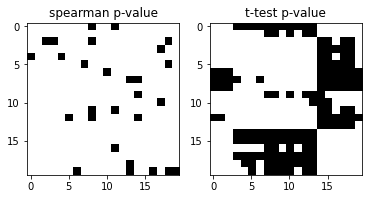

In [13]:
def visualize_p_values(threshold = 0.05):
    """
    This function turns visualizes the p-values. It transform all p-values above a threshold
    every pixel represents a p-value. All colored in white are above the given threshold.
    Every pixel that's above the threshold is colored white, all other pixels are black.
    @return: figure with 2 images representing p-values.
    """
    fig, ax = plt.subplots(1,2)
    coeffs = get_advanced_correlation_info()

    coeffs[:,:,1] = np.where(coeffs[:,:,1] > threshold, 0, 1)
    ax[0].imshow(coeffs[:,:,1], cmap='binary')
    ax[0].set_title('spearman p-value')


    coeffs[:,:,3] = np.where(coeffs[:,:,3] > threshold, 0, 1)
    ax[1].imshow(coeffs[:,:,3], cmap='binary')
    ax[1].set_title('t-test p-value')


    return plt.show()

visualize_p_values()

# Research questions
the rest of the document is dedicated to the answers of our research hypothesis

## Question 1
AI novice users prefer local to global explanations, where preference is defined as an overall higher score?



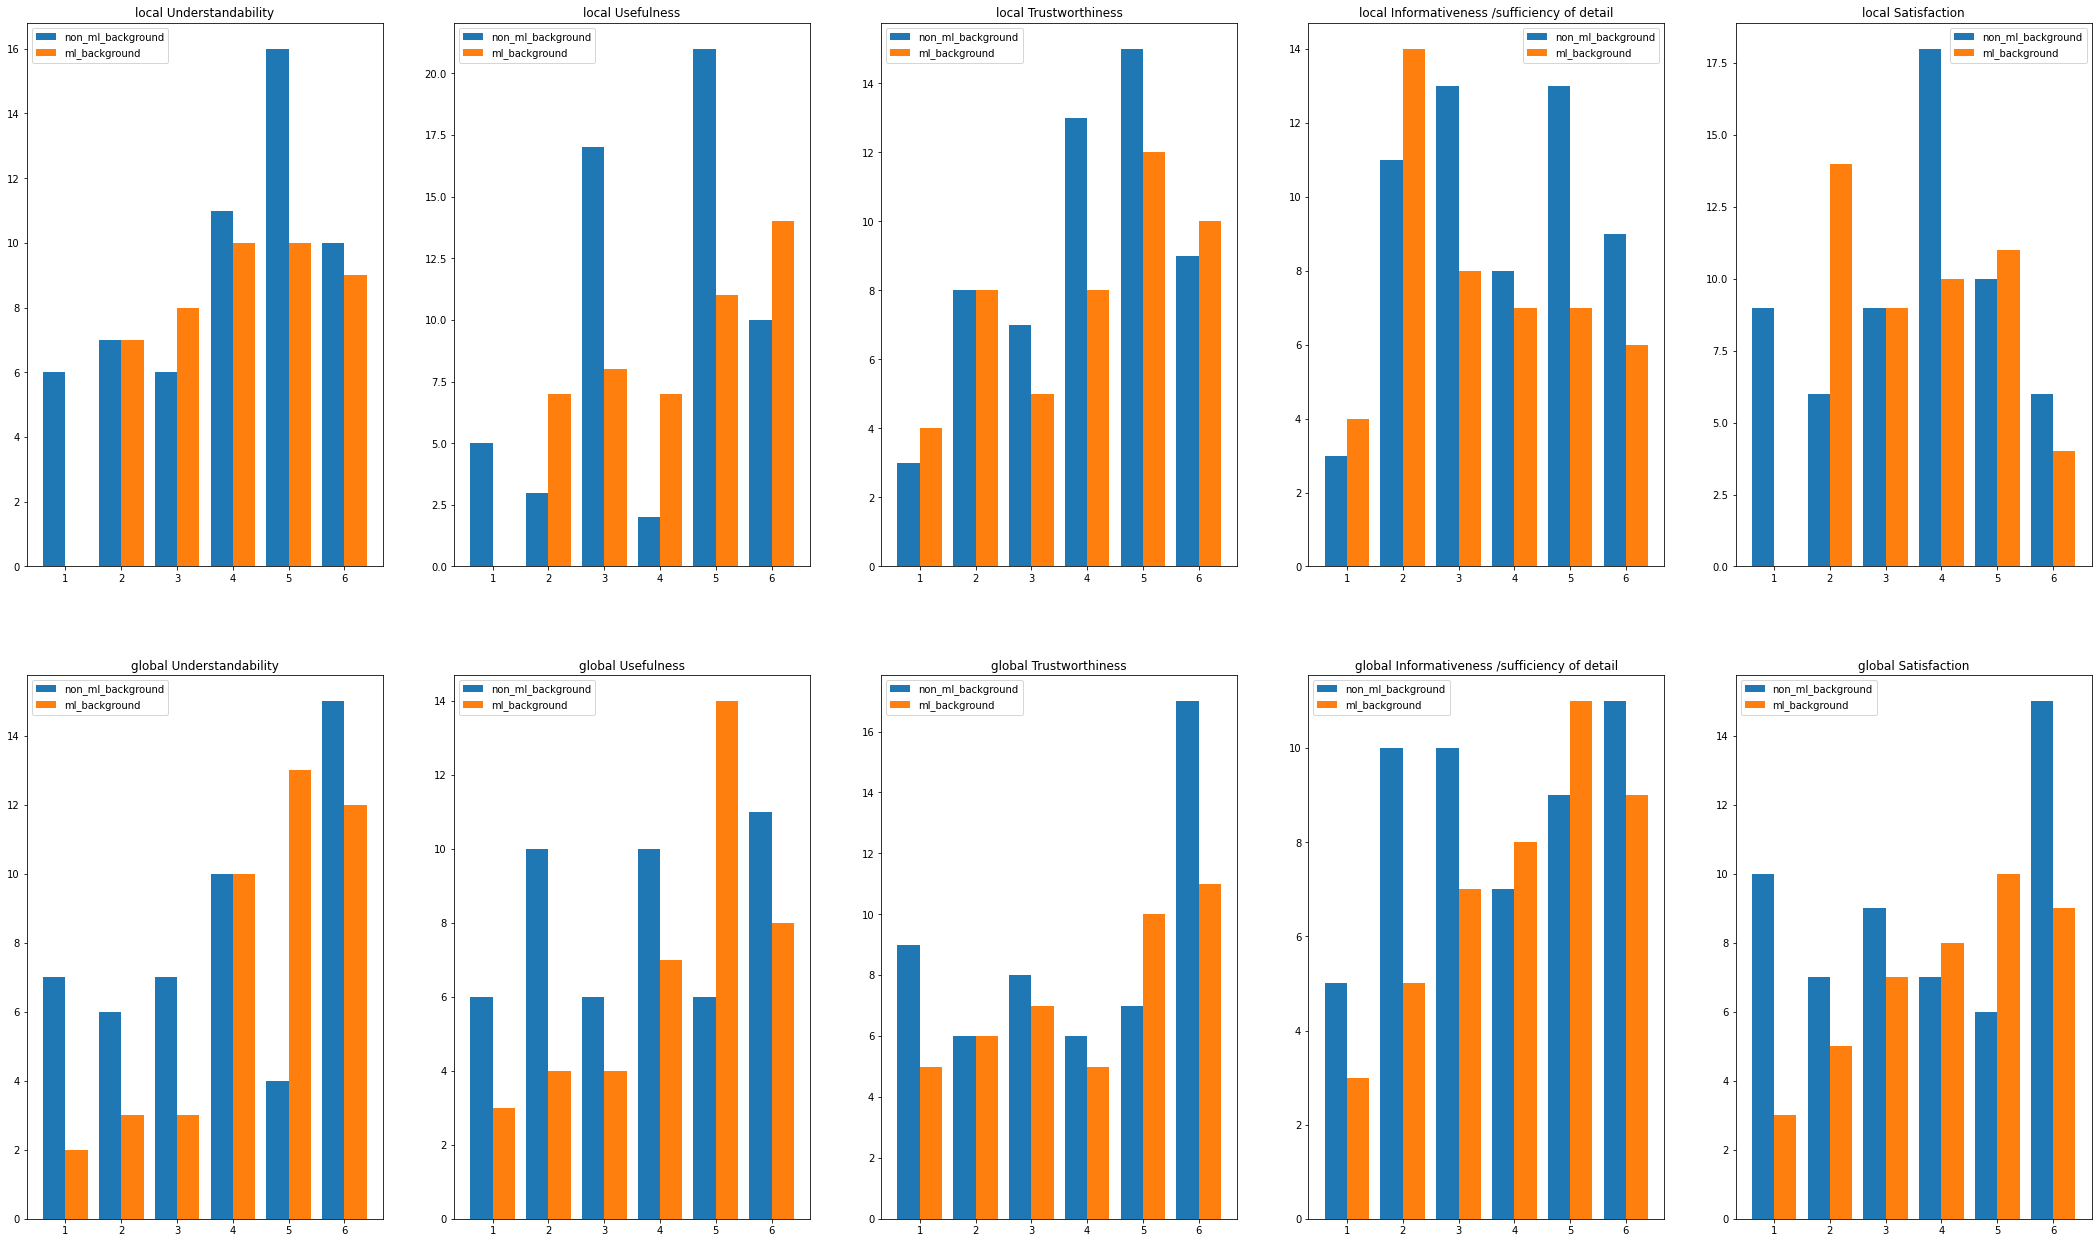

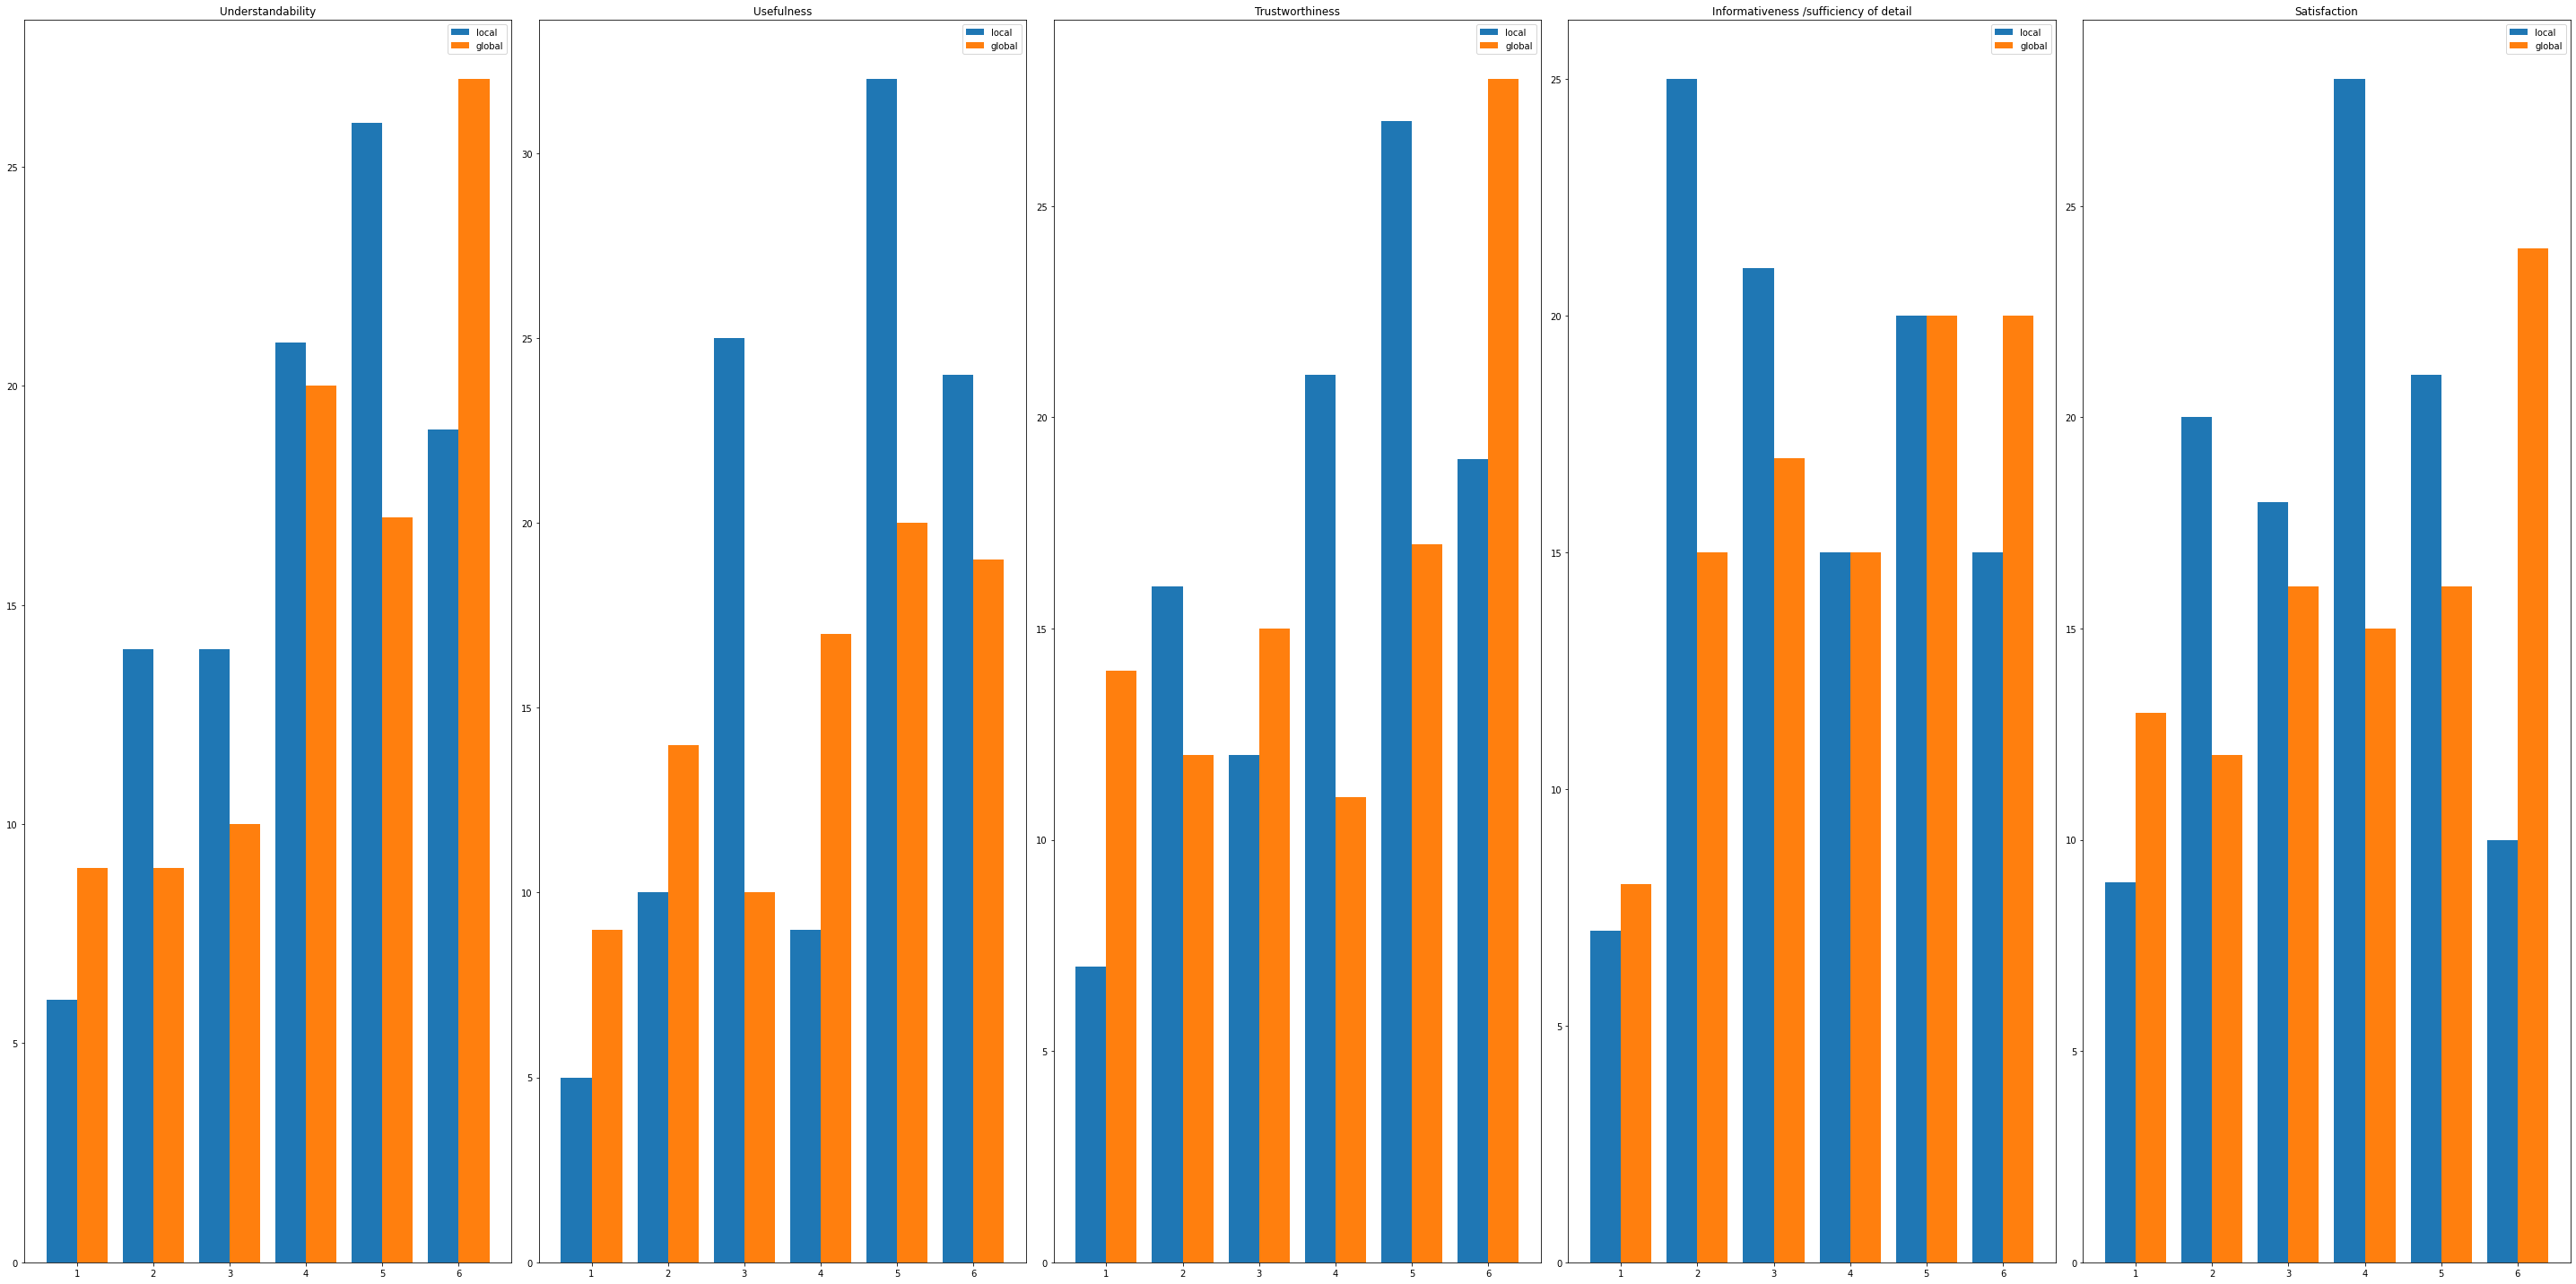

In [50]:
def get_local_vs_global_hist(drilldown=False, safe_fig=False):
    '''
    Creates histograms for local vs. global explanations.
    @param safe_fig:
    @param drilldown:
    @return:
    '''
    if drilldown:
        fig,axs = plt.subplots(2,5)
        fig.set_size_inches(37, 22)

        criteria = ['Understandability', 'Usefulness', 'Trustworthiness', 'Informativeness /sufficiency of detail', 'Satisfaction']
        for i, row, cat in zip([0,10],[0,1],['local', 'global']):
            for idx, crit in enumerate(criteria):
                col1 = i + idx + 5
                col2 = col1 + 5

                ml = np.column_stack((ml_background.iloc[:,col1].values, ml_background.iloc[:,col2].values))
                non_ml = np.column_stack((non_ml_background.iloc[:,col1].values, non_ml_background.iloc[:,col2].values))

                ml.reshape(1,ml.shape[0] * ml.shape[1])
                non_ml.reshape(1,non_ml.shape[0] * non_ml.shape[1])

                data = [non_ml, ml]
                axs[row,idx].set_title(cat + " " + crit)
                axs[row,idx].hist(data, bins=np.arange(1,8)-0.5, histtype='bar',  label=['non_ml_background', 'ml_background'])
                axs[row,idx].legend()
        if safe_fig:
            plt.savefig('data/images/drill_down_local_vs_global')


    else:
        fig, axs = plt.subplots(1,5)
        fig.set_size_inches(40, 20)
        criteria = ['Understandability', 'Usefulness', 'Trustworthiness', 'Informativeness /sufficiency of detail', 'Satisfaction']
        for i, cri in enumerate(criteria, start=5):
            lo_col = [i,i+5]
            glo_col = [i+10, i+15]
            loc_data = df.iloc[:,lo_col].values.reshape(df.shape[0] * 2,1)
            glo_data = df.iloc[:,glo_col].values.reshape(df.shape[0] * 2,1)
            data = np.column_stack((loc_data, glo_data))

            axs[i-5].set_title(cri)
            axs[i-5].hist(data, bins=np.arange(1,8)-0.5, histtype='bar', label = ['local', 'global'])
            axs[i-5].legend()

        plt.tight_layout()
        if safe_fig:
            plt.savefig('data/images/local_vs_global')
        plt.show()

get_local_vs_global_hist(drilldown=True, safe_fig=True)
get_local_vs_global_hist(drilldown=False, safe_fig=True)

In [15]:
def calculate_statistics(threshold=0.05, dataset=non_ml_background):
    '''
    This function calculates a statistic to assess if local or global explanations are better.
    @param threshold: the threshold applied to the Welch t-test to see if something is counted as significant
    @param dataset: the dataset to use.
    @return: creates a pandas table with survey criteria as rows and evaluation criteria as columns
    '''
    vals = np.zeros((5,4))
    for idx in range(5):


        loc = dataset.iloc[:,idx+5].append(dataset.iloc[:,idx+10])
        glo = dataset.iloc[:,idx+15].append(dataset.iloc[:,idx+20])
        mean_l = np.mean(loc)
        mean_g = np.mean(glo)
        glo_greq_loc = mean_l >= mean_g
        stat, p = sc.ttest_ind(loc, glo, equal_var=False)
        significant = p > threshold

        vals[idx,0] = mean_l
        vals[idx,1] = mean_g
        vals[idx,2] = glo_greq_loc
        vals[idx,3] = significant
    differences = pd.DataFrame(index=['Understandability', 'Usefulness', 'Trustworthiness', 'Informativeness /sufficiency of detail', 'Satisfaction'],
                               columns=['mean_local', 'mean_global', 'local >= global', 'significant (Welch)'], data=vals
                               )
    return differences

calculate_statistics()

,mean_local,mean_global,local >= global,significant (Welch)
Understandability,4.258065,4.532258,0.0,1.0
Usefulness,4.233871,4.362903,0.0,1.0
Trustworthiness,4.354839,4.330645,1.0,1.0
Informativeness /sufficiency of detail,4.032258,4.258065,0.0,1.0
Satisfaction,3.766129,4.104839,0.0,1.0


as we can see from the table above, global explanations seem to perform better than local ones.
This goes for all categories except of Trustworthiness.
The difference is significant according to a Welch's t-test with threshold = 0.05

## question 2
Is there a preference towards local or global explanations for AI experts, where preference is defined as an overall higher score?

In [16]:

calculate_statistics(dataset=ml_background)

,mean_local,mean_global,local >= global,significant (Welch)
Understandability,4.375000,4.770833,0.0,1.0
Usefulness,4.416667,4.687500,0.0,1.0
Trustworthiness,4.041667,4.208333,0.0,1.0
Informativeness /sufficiency of detail,3.520833,4.375000,0.0,0.0
Satisfaction,3.625000,4.416667,0.0,0.0


 as we can see in the table, for AI experts the picture is quite similar to AI novice users.
The only notable difference is, that AI users acchive better scores in all categories without exception.
Again these differences are significant based on the Students t-test with threshold = 0.05

## question 3
Explanations (in general) increase users’ trust in a system. (trustworthiness)

To answer this question it has to be assumed, that all participants interpreted the likert scale correctly.
Thus, 4 is a neutral answer and any answer lower/higher than 4 is a decrease/increase.
Hence, it has to be checked if the median, and the mean is above or below 4.
Trustworthiness was assessed with the third question for each explanation

In [17]:
def assess_item(item_nr=0, dataset=df):
    '''
    This function calculates the mean and the median of a given item
    This uses the fact that we have 5 similar items per question
    @param item_nr: item number is 0 based, implying that the first item per question is item_nr=0
    @param dataset: the dataset for which a item should be
    @return: creates a table with different XAI-methods as rows and mean and median as colunns
    '''
    rows = ['lime', 'shap_local', 'shap_global', 'pdp']
    values = np.zeros((4,3))
    items = np.arange(start=item_nr+5, stop=25,step=5)
    for idx, pos in enumerate(items):
        data = dataset.iloc[:,pos]
        mean = np.mean(data)
        median = np.median(data)
        std = np.std(data)
        values[idx, 0] = mean
        values[idx, 1] = median
        values[idx, 2] = std
    results = pd.DataFrame(
        columns=['mean', 'median', 'std'],
        index=rows,
        data=values
    )
    return results

assess_item(2)

,mean,median,std
lime,4.654545,5.0,1.675689
shap_local,3.781818,4.0,1.557281
shap_global,3.827273,3.5,2.043211
pdp,4.727273,5.0,1.783302


As we can see in the table above explanations provided by lime and pdp seems to increase the trust in the AI system.
However, shap_global performs acceptably, meaning that it does not influence the mean trustworthiness of our population.
Shap_local on the other decreases the mean trust below 4.

## question 4
Explanations help AI novices to (better) understand a ML system.

To answer this question the same assumptions as for question 3 apply.
Understandability was assessed with the first question for each explanation.


In [18]:
assess_item(item_nr=1, dataset=non_ml_background)#


,mean,median,std
lime,4.677419,5.0,1.573718
shap_local,3.790323,3.0,1.595226
shap_global,3.483871,3.0,1.965361
pdp,5.241935,6.0,1.698533


This table shows that the Understandability of only half the explanations is greater than 4.
As with trustworthiness shap provides scores lower or equal to 4.
However pdp seems to provide overwhelmingly positive results. Mean and Median arethe highest of all XAI methods compared.
Furthermore, it's noticable, that the median of pdp is at 6 and therefore only 1 point below the maximum possible.



## Question 5

Hypothesis: Between LIME and SHAP local explanations, AI novices prefer LIME. 
#(preference = overall higher scores for all evaluation criteria)

First we need to define AI novices and AI expert instances. Then the visualization is based on a single chart per criteria. At the same time, each chart contains two histograms, one for each XAI method. (Double click on the visualization to zoom it).

Morover, a table is added containing the mean of the votes and standard deviation per criteria and per method. 

Criteria             Mean LIME    Mean SHAP    Std LIME    Std SHAP
-----------------  -----------  -----------  ----------  ----------
Understandability      4.86111      4           1.70217     1.66667
Usefulness             4.75         3.83333     1.55233     1.5899
Trustworthiness        4.77778      4.11111     1.66852     1.52348
Informativeness        4.61111      3.61111     1.67129     1.60343
Satisfaction           4.22222      3.63889     1.79677     1.63559



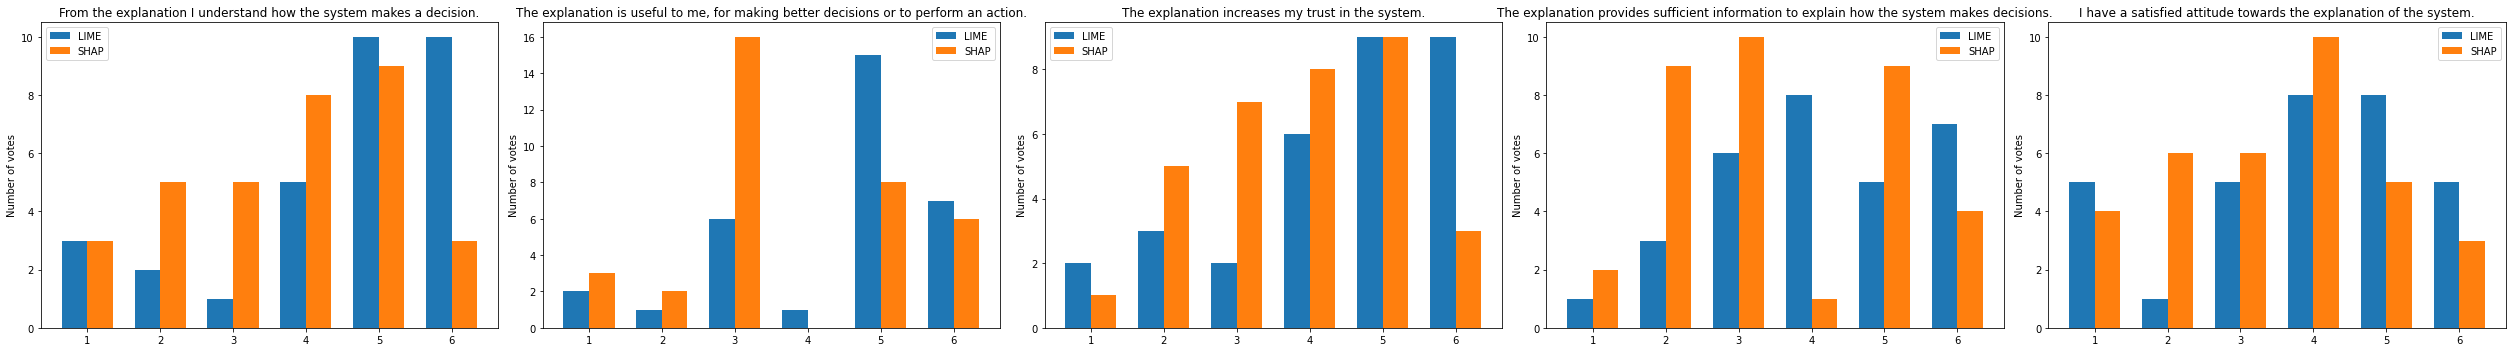

In [24]:
#Defining AI novices and AI expert instances

ai_novice = df[df['question 4'] == '0']
ai_novice = ai_novice.append(df[df['question 4'] == '1'])

ai_expert = df.drop(index=ai_novice.index)

#Question 5 analysis

from scipy.stats import norm
from tabulate import tabulate

def get_histo_grid(safe_fig=False):
    
    fig, axs = plt.subplots(1,5)
    fig.set_size_inches(35, 5)
    # fig.subplots_adjust(hspace=1.0, wspace=1.0)
    table = [] 
    mu1=[]
    mu2=[]
    std1=[]
    std2=[]
        
    
    for i in range(6,11):
        data = [ai_novice[f'question {i}'], ai_novice[f'question {i+5}']]
        row = 1
        col = (i-6)%5
        
        axs[col].hist(data, bins=np.arange(1,8)-0.5, histtype='bar',  label=['LIME','SHAP'],rwidth=0.7)
        axs[col].set_title(original_column_names[i-1])
        axs[col].legend()
        axs[col].set_ylabel('Number of votes')
        
        data1 = ai_novice[f'question {i}']
        data2 = ai_novice[f'question {i+5}']
        
        mu, std = norm.fit(data1)
        mu3, std3 = norm.fit(data2)
        
        mu1.append(mu)
        mu2.append(mu3)
        std1.append(std)
        std2.append(std3)
        
        criteria = ['Understandability','Usefulness','Trustworthiness','Informativeness','Satisfaction']
        column = criteria[i-6], mu1[i-6],mu2[i-6],std1[i-6],std2[i-6]
        table.append(column)
    
    
    
    print(tabulate((table), headers=['Criteria', 'Mean LIME', 'Mean SHAP', 'Std LIME' ,'Std SHAP']))
    print('')
    plt.tight_layout()
    if safe_fig:
        plt.savefig('data/images/Answers Question 5')

get_histo_grid(safe_fig=True)


## Question 6

Hypothesis: Explanations provide additional information about the system.(informativeness).
This analisys just involve comparing the histograms of the four XAI methods for the survey question 'The explanation provides sufficient information to explain how the system makes decisions'.

The histograms plot are for the completion of the notebook (double click on it to zoom it). In the report will be the Tableau ones.

Method          Mean      Std
-----------  -------  -------
LIME         4.35     1.73037
SHAP-local   3.4      1.59374
SHAP-global  3.56667  1.78294
PDP          5.13333  1.59391



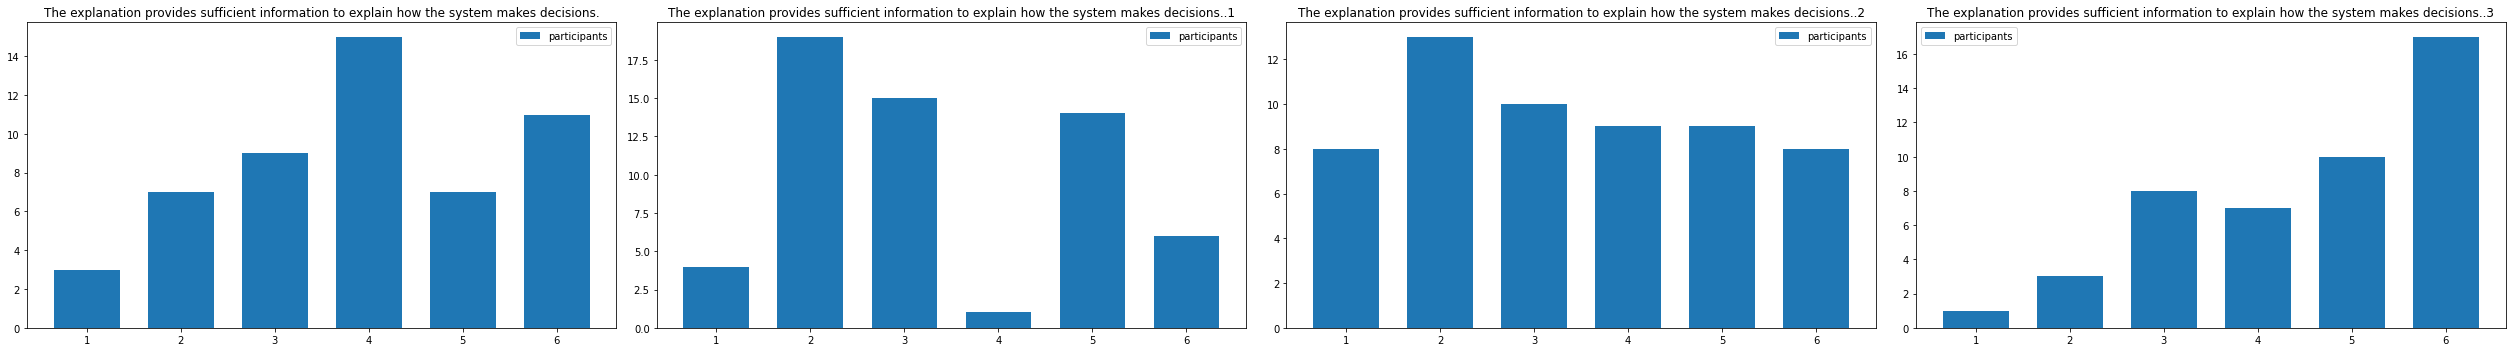

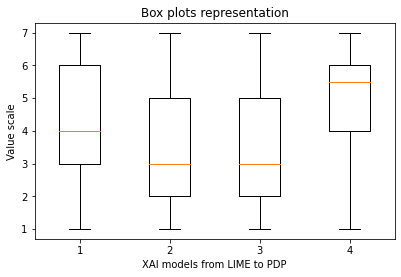

In [35]:
#Histograms for question 6:H: Explanations provide additional information about the system.(informativeness)

def get_histo_grid(safe_fig=False):
  
    fig, axs = plt.subplots(1,4)
    fig.set_size_inches(35,5 )
    # fig.subplots_adjust(hspace=1.0, wspace=1.0)
    feature_list = ["9", "14", "19", "24"]
    feature_list = list(map(int, feature_list))
    counter=0
    table = [] 
    mu1=[]
    std1=[]
    data_boxplot=[]
    
    for i in feature_list:
        data = df[f'question {i}']
        col = (i-6)//5
        row = 1
        # axs[row,col].set_size_inches(18.5, 10.5)
        axs[col].hist(data, bins=np.arange(1,8)-0.5, histtype='bar',  label=['participants'],rwidth=0.7)
        axs[col].set_title(original_column_names[i-1])
        axs[col].legend()
        
        mu, std = norm.fit(data)
        mu1.append(mu)
        std1.append(std)
        
        methods = ['LIME','SHAP-local','SHAP-global','PDP']
        column = methods[counter], mu1[counter], std1[counter]
        table.append(column)
        counter = counter+1
        data_boxplot.append(data)
        
    print(tabulate((table), headers=['Method', 'Mean', 'Std']))
    print('')
    plt.tight_layout()
    if safe_fig:
        plt.savefig('data/images/Answers Question 6')
     
    #Box plots representation
    fig = plt.figure(figsize =(5, 3))
    ax = fig.add_axes([1, 1, 1, 1])
    ax.set_title('Box plots representation')
    bp = ax.boxplot(data_boxplot)
    plt.xlabel("XAI models from LIME to PDP")
    plt.ylabel("Value scale")
    plt.show()
    
get_histo_grid(safe_fig=True)


Each boxplot represent an histogram, we can compare by observation their medians, quartiles and outliers. 

## Question 7

Question: Are explanations useful to AI novices and AI experts? (usefulness)
This analisys just involve comparing the histograms of the four XAI methods for the survey question 'The explanation is useful to me, for making better decisions or to perform an action'.

The histograms plot are for the completion of the notebook (double click on it to zoom it). In the report will be the Tableau ones.

Method          Mean      Std
-----------  -------  -------
LIME         4.8      1.48099
SHAP-local   3.88333  1.52853
SHAP-global  3.8      1.9218
PDP          5.26667  1.63163



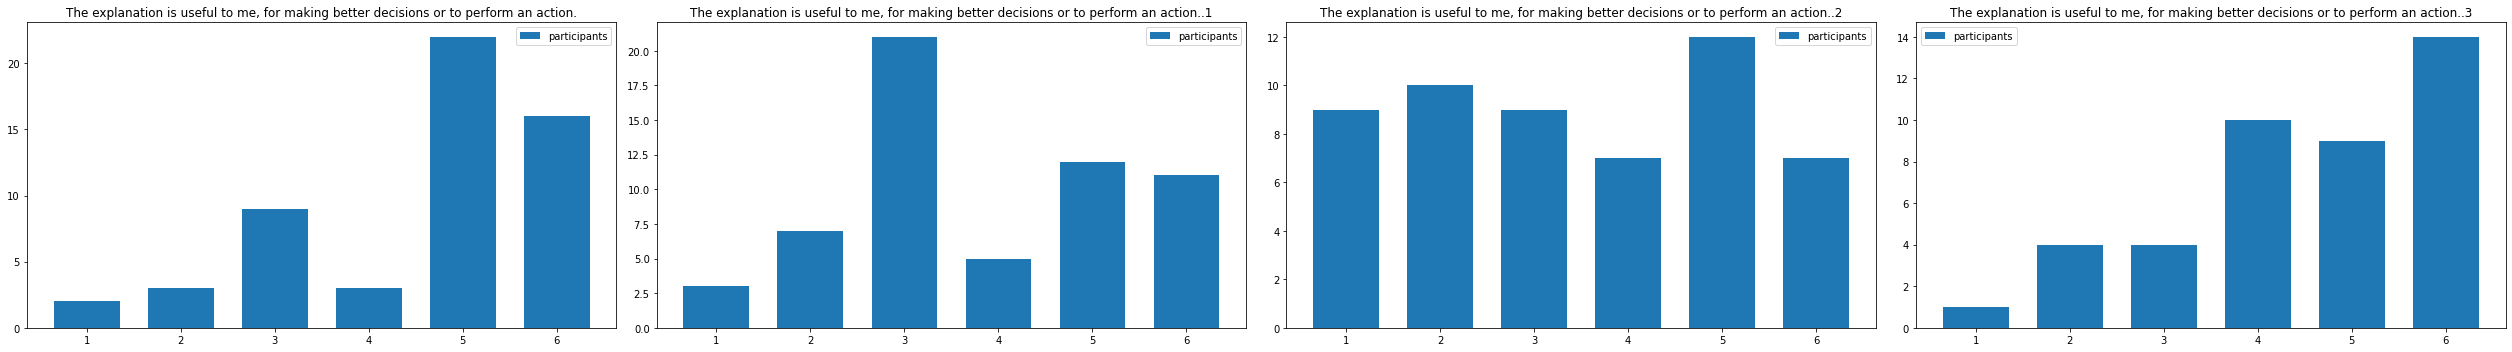

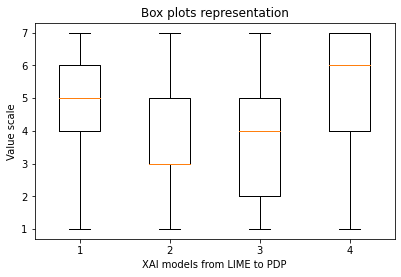

In [26]:
#Histograms for question 7:Q: Are explanations useful to AI novices and AI experts? (usefulness)

def get_histo_grid(safe_fig=False):
    """
    This function creates a histogram for each question.
    The data is segmented based on ML-Background
    @param safe_fig: defines if the figure is saved as .png
    @return: None
    """
    fig, axs = plt.subplots(1,4)
    fig.set_size_inches(35,5 )
    # fig.subplots_adjust(hspace=1.0, wspace=1.0)
    feature_list = ["7", "12", "17", "22"]
    feature_list = list(map(int, feature_list))
    counter=0
    table = [] 
    mu1=[]
    std1=[]
    data_boxplot=[]
    
    for i in feature_list:
        data = df[f'question {i}']
        col = (i-6)//5
        row = 1
        
        axs[col].hist(data, bins=np.arange(1,8)-0.5, histtype='bar',  label=['participants'],rwidth=0.7)
        axs[col].set_title(original_column_names[i-1])
        axs[col].legend()
        
        mu, std = norm.fit(data)
        mu1.append(mu)
        std1.append(std)
        
        methods = ['LIME','SHAP-local','SHAP-global','PDP']
        column = methods[counter], mu1[counter], std1[counter]
        table.append(column)
        counter = counter+1
        data_boxplot.append(data)
    
    print(tabulate((table), headers=['Method', 'Mean', 'Std']))
    print('')
    plt.tight_layout()
    if safe_fig:
        plt.savefig('data/images/Answers Question 7')
        
    #Box plots representation
    fig = plt.figure(figsize =(5, 3))
    ax = fig.add_axes([1, 1, 1, 1])
    ax.set_title('Box plots representation')
    bp = ax.boxplot(data_boxplot)
    plt.xlabel("XAI models from LIME to PDP")
    plt.ylabel("Value scale")

    plt.show()

get_histo_grid(safe_fig=True)


Each boxplot represent an histogram, we can compare by observation their medians, quartiles and outliers. 

## Question 8 

Question: Are users more satisfied with a system if they are given explanations of the system? (satisfaction)

This analisys just involve comparing the histograms of the four XAI methods for the survey question 'I have a satisfied attitude towards the explanation of the system.'.

The histograms plot are for the completion of the notebook (double click on it to zoom it). In the report will be the Tableau ones.

Method          Mean      Std
-----------  -------  -------
LIME         4.1      1.67033
SHAP-local   3.51667  1.46619
SHAP-global  3.51667  1.8752
PDP          5.1      1.64012



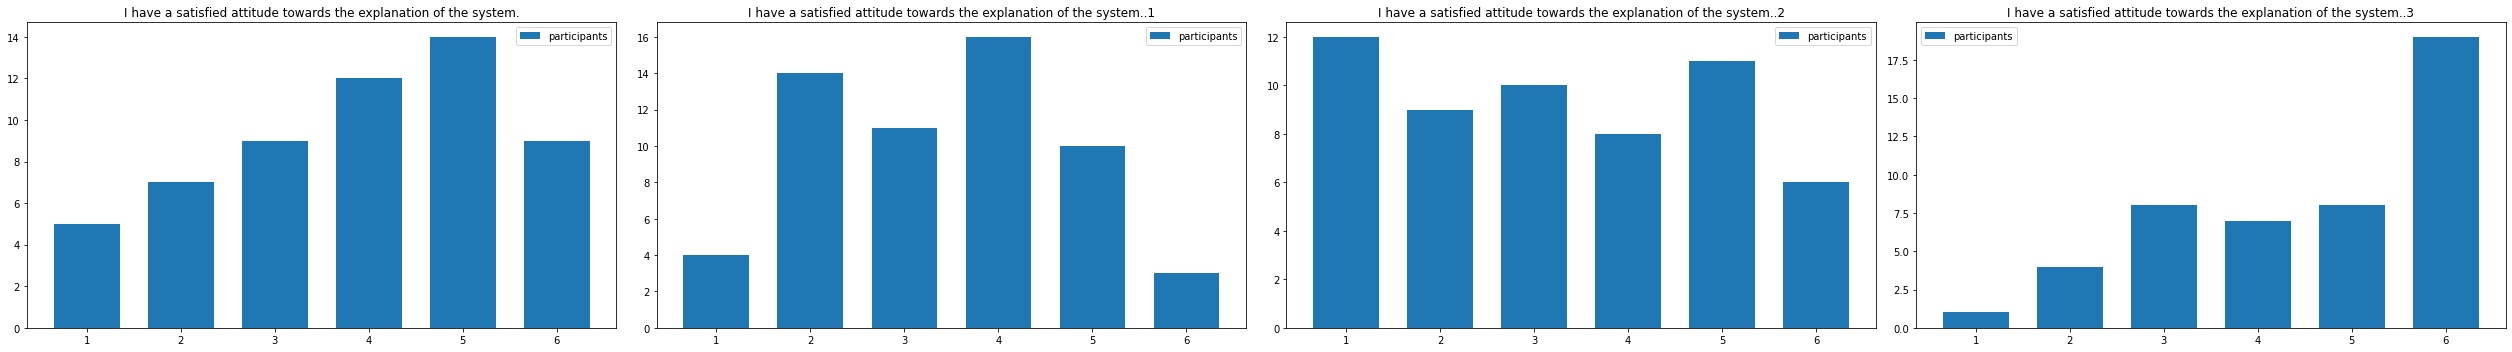

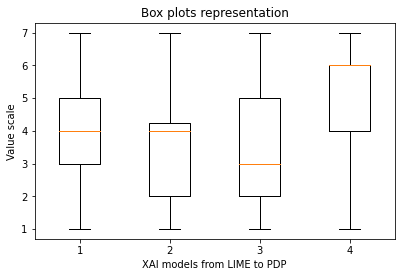

In [27]:
#Histograms for question 8:Q: Are users more satisfied with a system if they are given explanations of the system? (satisfaction)

def get_histo_grid(safe_fig=False):
    """
    This function creates a histogram for each question.
    The data is segmented based on ML-Background
    @param safe_fig: defines if the figure is saved as .png
    @return: None
    """
    fig, axs = plt.subplots(1,4)
    fig.set_size_inches(35,5 )
    # fig.subplots_adjust(hspace=1.0, wspace=1.0)
    feature_list = ["10", "15", "20", "25"]
    feature_list = list(map(int, feature_list))
    counter=0
    table = [] 
    mu1=[]
    std1=[]
    data_boxplot=[]
    
    for i in feature_list:
        data = df[f'question {i}']
        col = (i-6)//5
        row = 1
        
        axs[col].hist(data, bins=np.arange(1,8)-0.5, histtype='bar',  label=['participants'],rwidth=0.7)
        axs[col].set_title(original_column_names[i-1])
        axs[col].legend()
        
        mu, std = norm.fit(data)
        mu1.append(mu)
        std1.append(std)
        
        methods = ['LIME','SHAP-local','SHAP-global','PDP']
        column = methods[counter], mu1[counter], std1[counter]
        table.append(column)
        counter = counter+1
        data_boxplot.append(data)
    
    print(tabulate((table), headers=['Method', 'Mean', 'Std']))
    print('')
    plt.tight_layout()
    if safe_fig:
        plt.savefig('data/images/Answers Question 8')
        
    #Box plots representation
    fig = plt.figure(figsize =(5, 3))
    ax = fig.add_axes([1, 1, 1, 1])
    ax.set_title('Box plots representation')
    bp = ax.boxplot(data_boxplot)
    plt.xlabel("XAI models from LIME to PDP")
    plt.ylabel("Value scale")
  
    plt.show()

get_histo_grid(safe_fig=True)


Each boxplot represent an histogram, we can compare by observation their medians, quartiles and outliers. 

Further explanation would be given based on our decisions these days


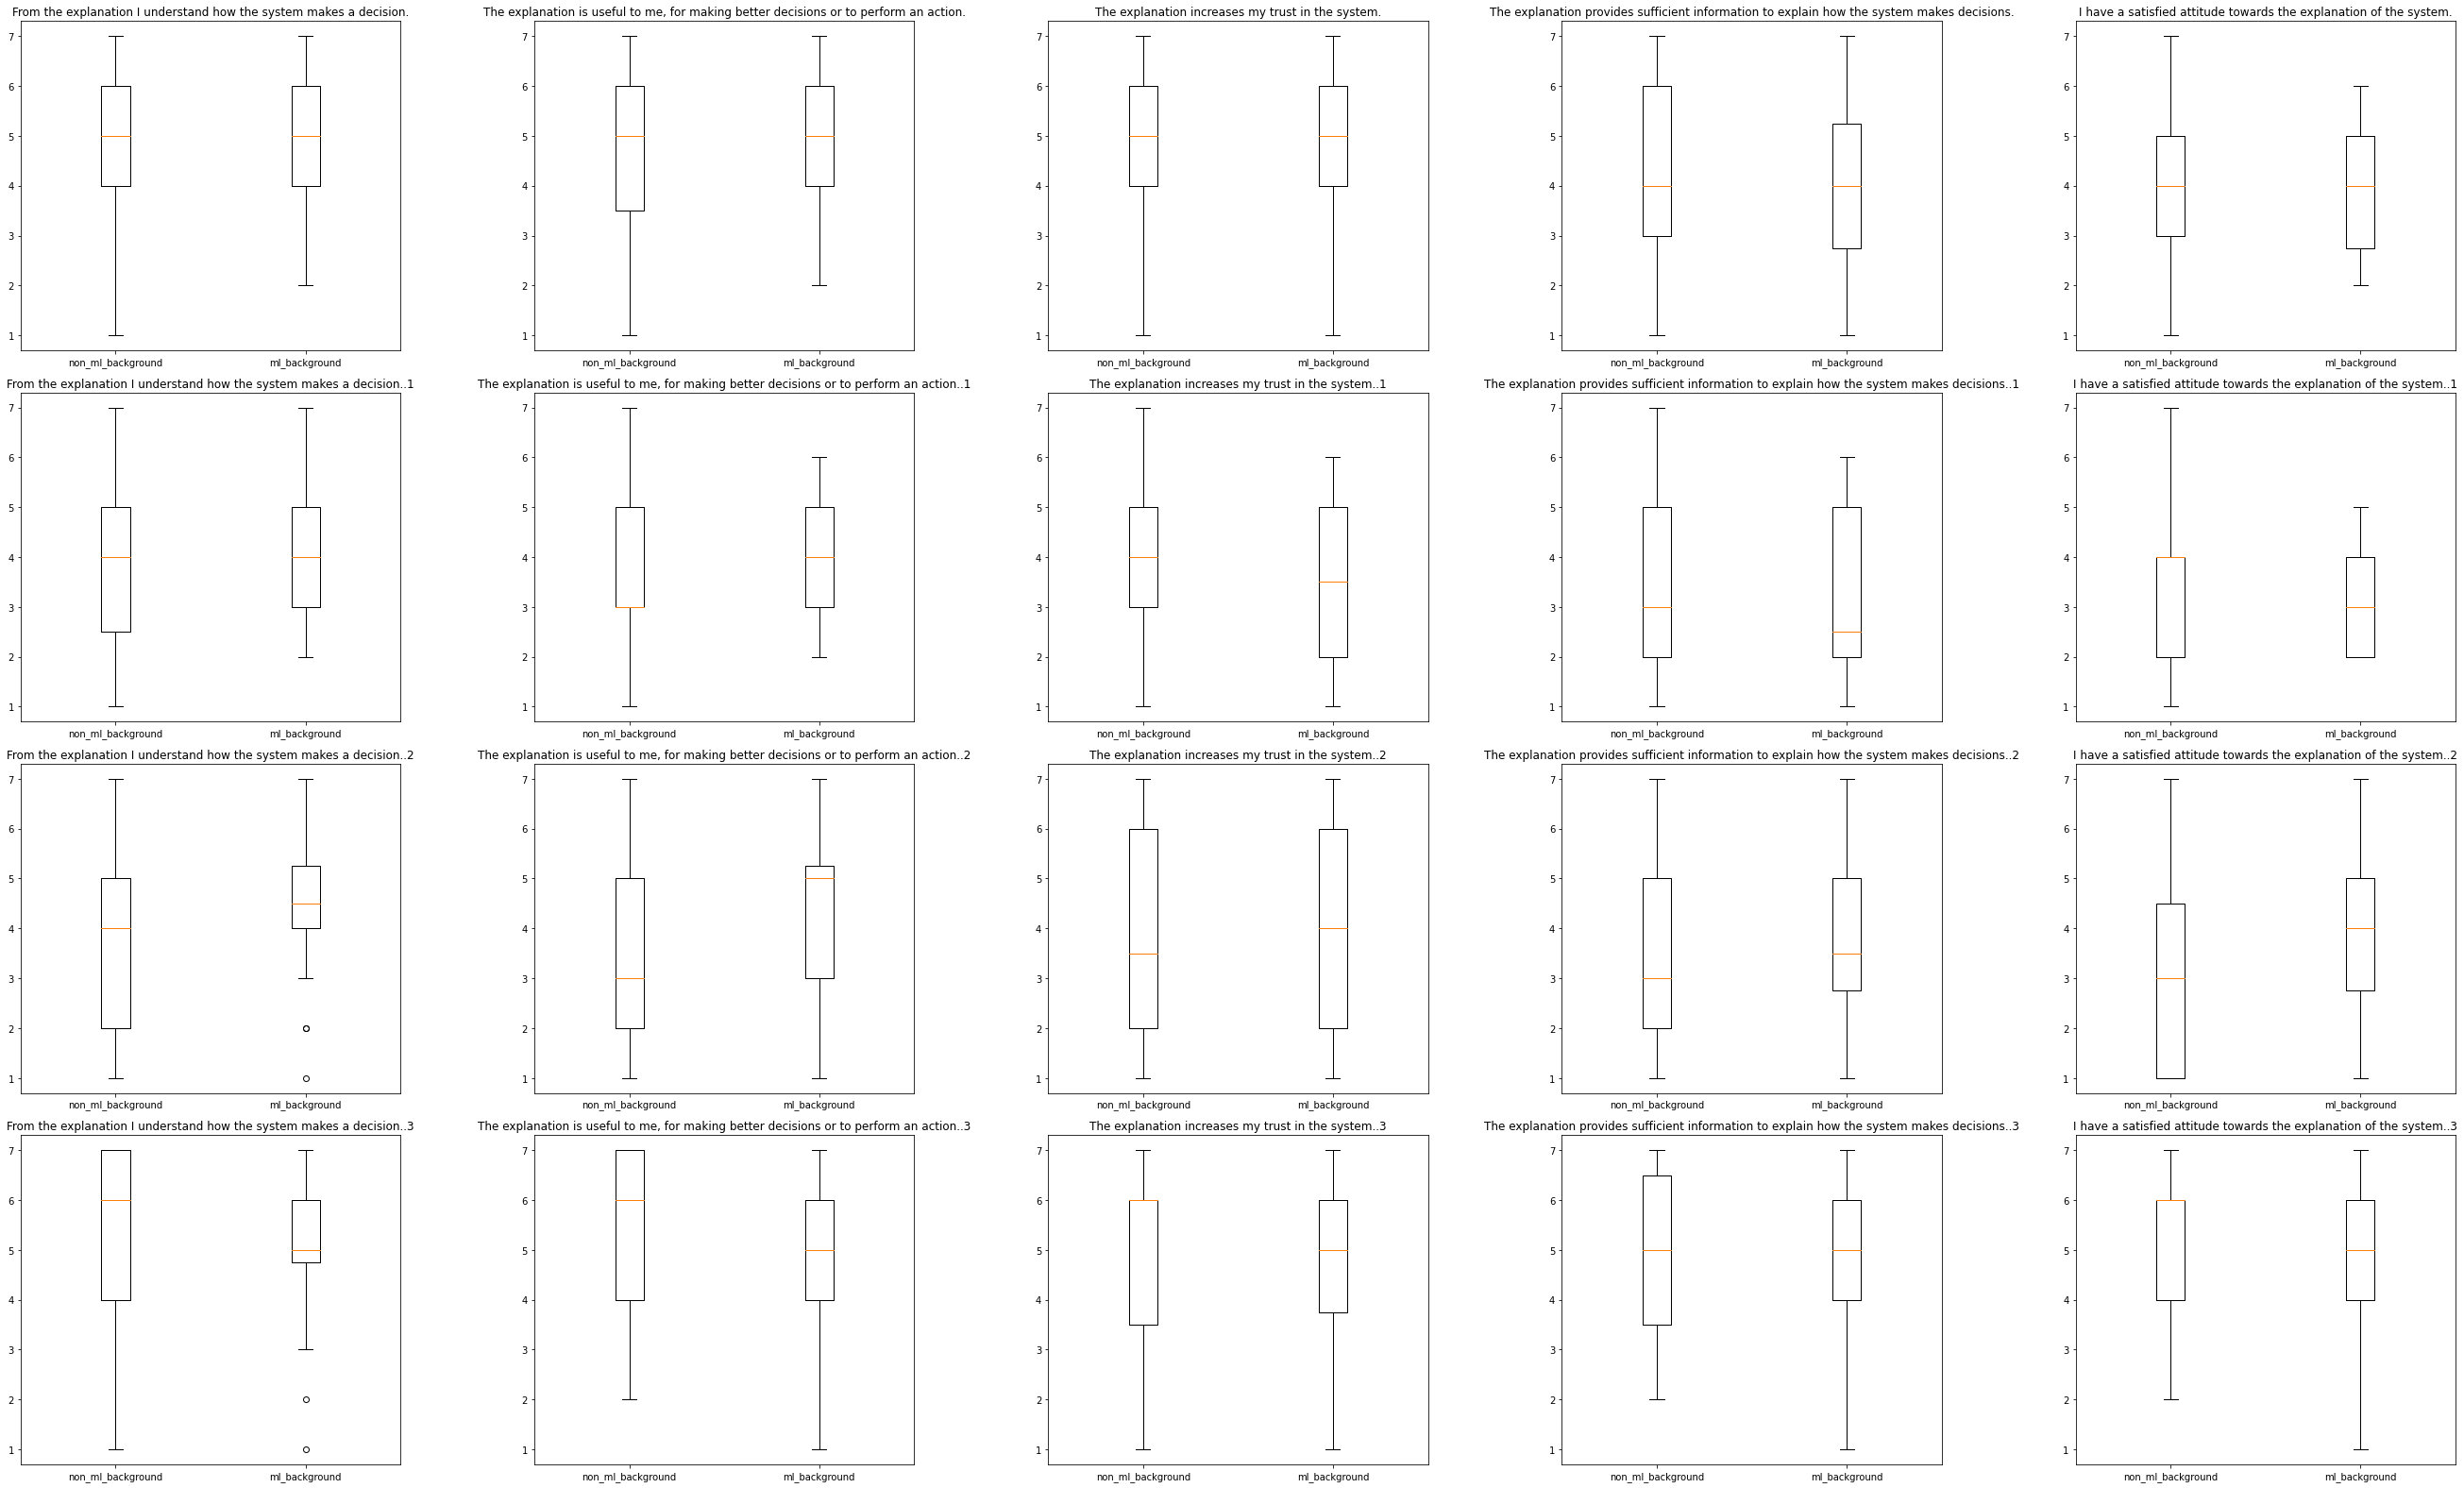

In [23]:
# cautiuon, bootstrapping is enabled
def get_box_grid(safe_fig=False):
    """
    This function creates a box-plot for each question.
    The data is segmented based on ML-Background
    @param safe_fig: defines if the figure is saved as .png
    @return: None
    """
    fig, axs = plt.subplots(4,5)
    fig.set_size_inches(37, 22)

    for i in range(6,26):

        data = [non_ml_background[f'question {i}'].values, ml_background[f'question {i}'].values]
        row = (i-6)//5
        col = (i-6)%5
        axs[row,col].boxplot(data, bootstrap=10000)


        axs[row,col].set_title(original_column_names[i-1])
        axs[row,col].set_xticklabels(['non_ml_background', 'ml_background'])
    plt.tight_layout()
    if safe_fig:
        plt.savefig('data/images/box_grid')

get_box_grid(safe_fig=True)

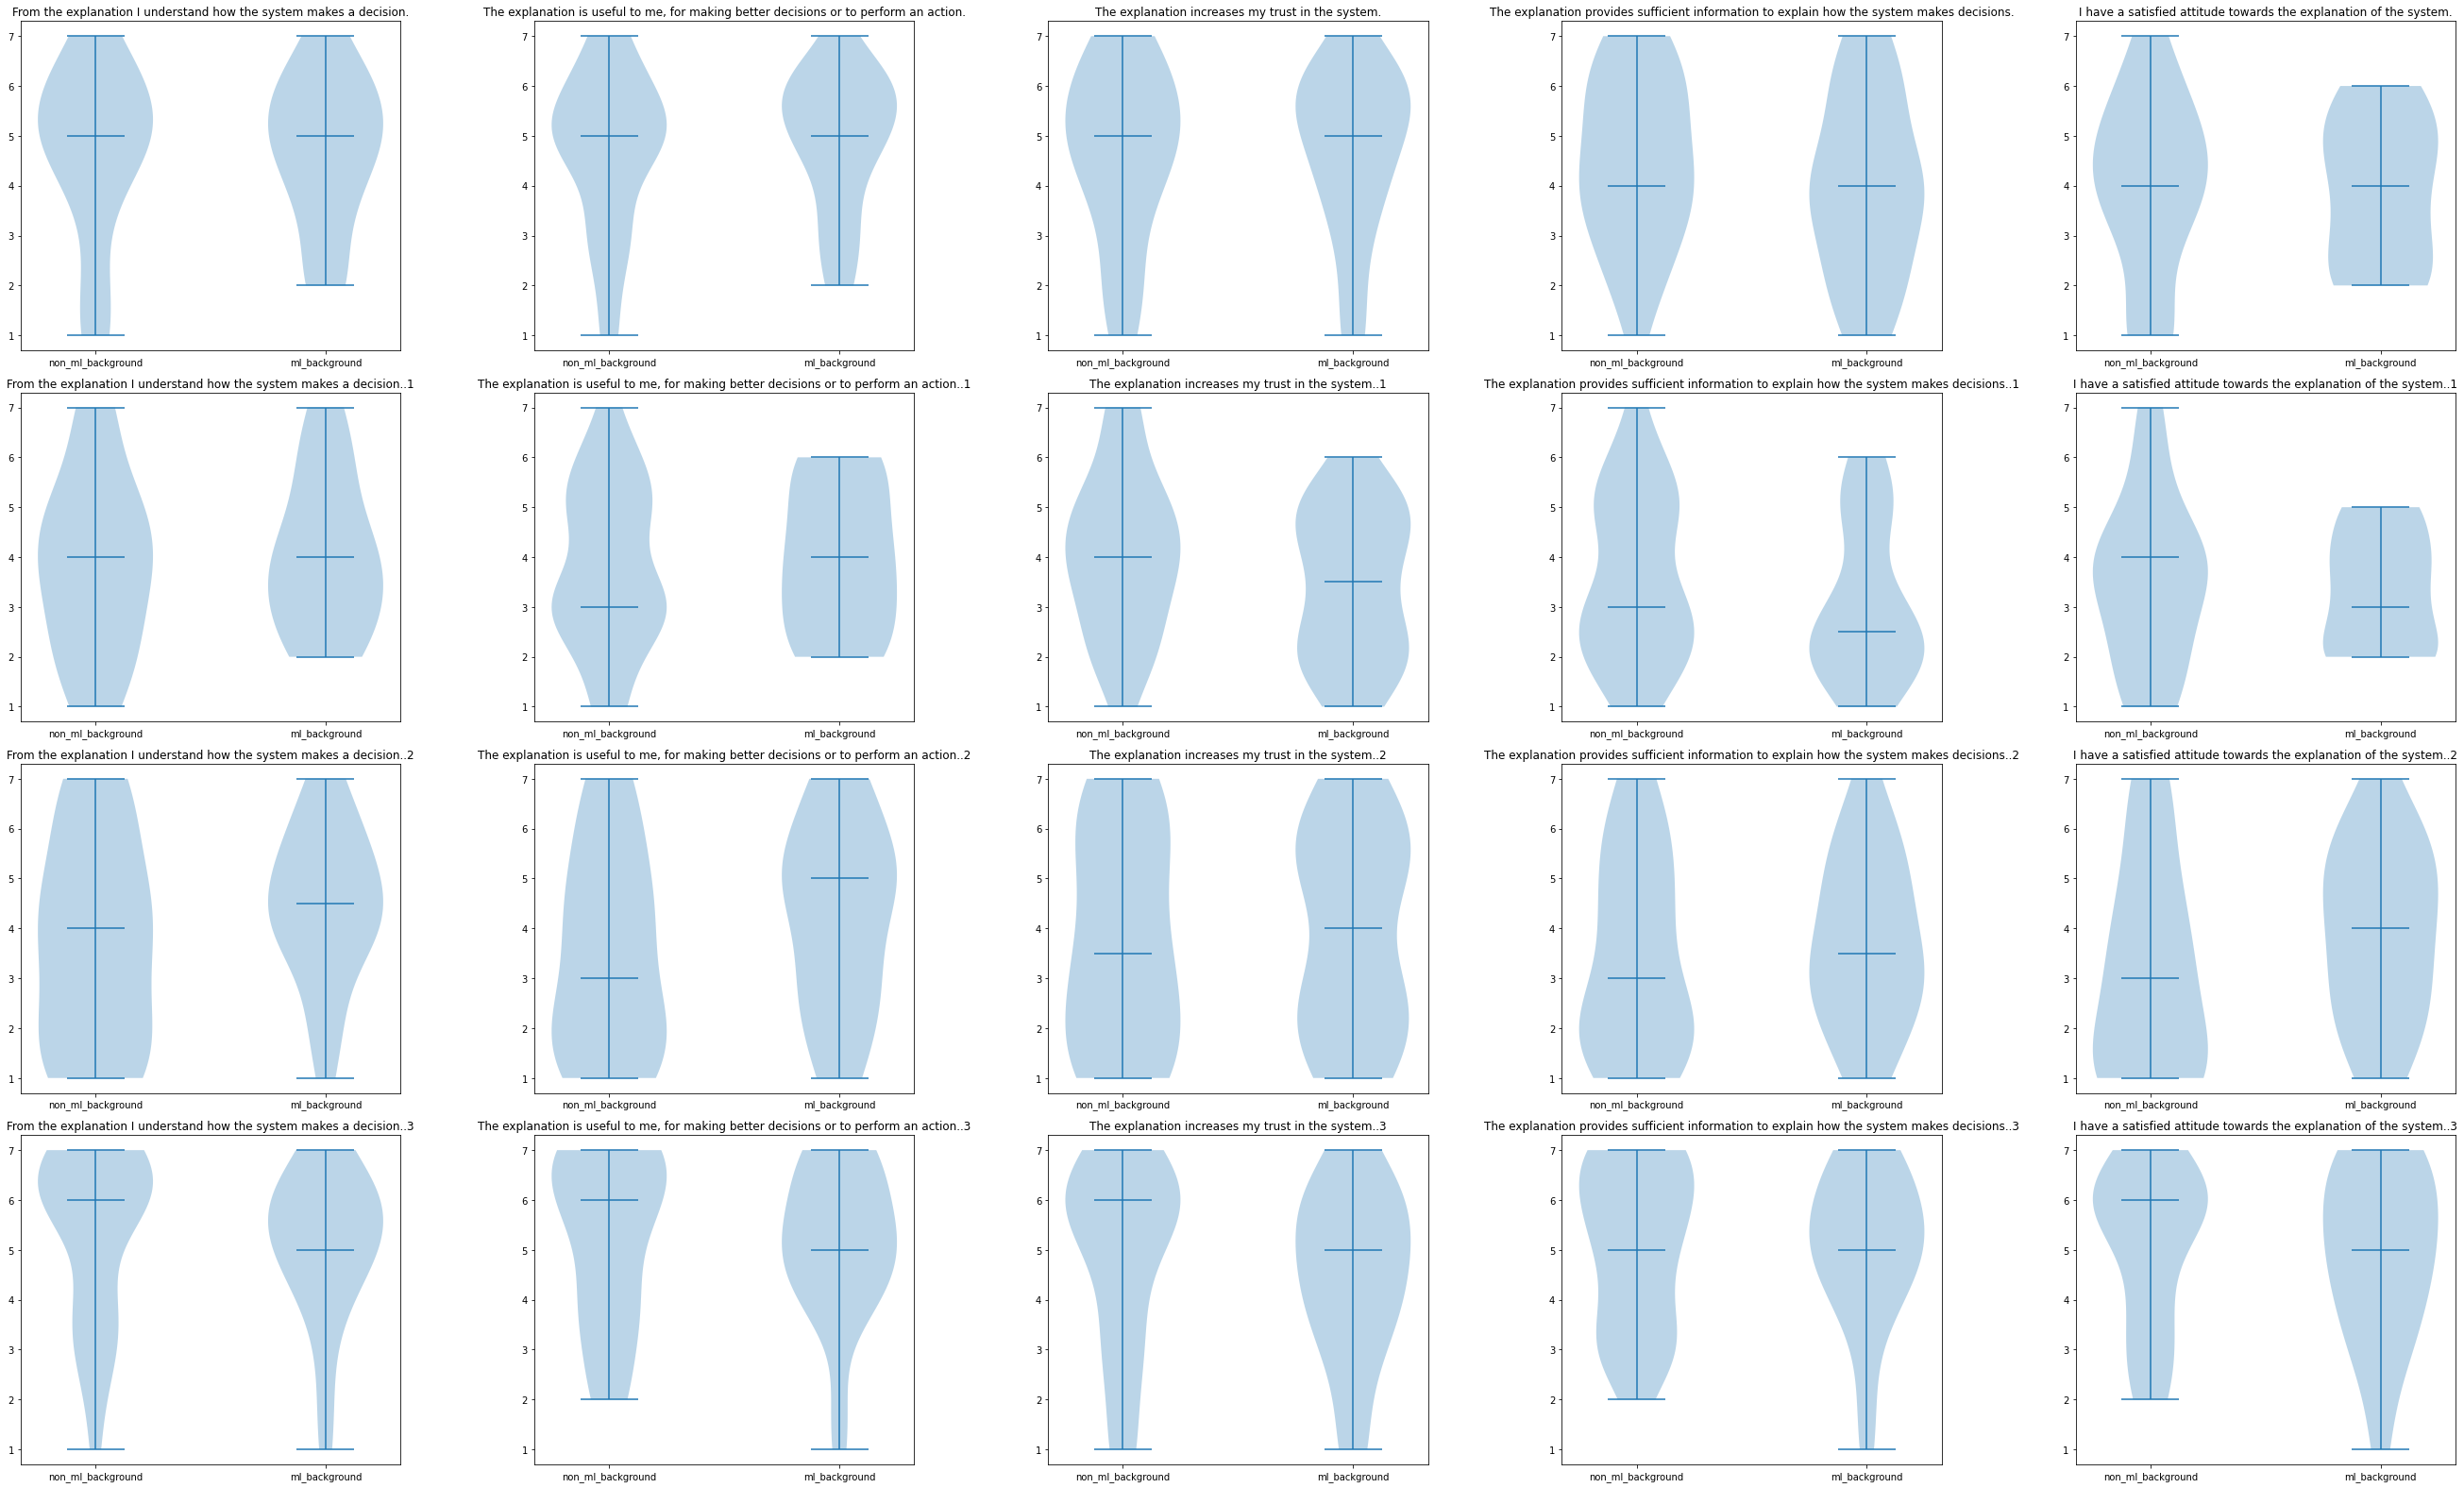

In [24]:
def get_violin_grid(safe_fig=False):
    """
    This function creates a violinplot for each question.
    The data is segmented based on ML-Background
    @param safe_fig: defines if the figure is saved as .png
    @return: None
    """
    fig, axs = plt.subplots(4,5)
    fig.set_size_inches(37, 22)

    for i in range(6,26):

        data = [non_ml_background[f'question {i}'].values, ml_background[f'question {i}'].values]
        row = (i-6)//5
        col = (i-6)%5
        axs[row,col].violinplot(data, showmedians=True)


        axs[row,col].set_title(original_column_names[i-1])
        axs[row,col].set_xticks([1,2])
        axs[row,col].set_xticklabels(['non_ml_background', 'ml_background'])
    plt.tight_layout()
    if safe_fig:
        plt.savefig('data/images/violin_grid')


get_violin_grid(safe_fig=True)

## remarkable observations
- pdp explanations get higher or equal median from non_ml_people in all categories


In [25]:
def assess_xai_method(xai_nr = 0):
    '''
    This function provides quick insights into a XAI Method. It compares means and medians for each of the 5 criterias.
    and performs a welch test for each categorie
    @param xai_nr: 0-indexed; number of XAI method to be assessed. 0 = Lime, 1 = shap local, 2 = shap global, 3 = pdp
    @return: Table with columns for mean, median aggregated by ML knowledge.
    '''
    results = np.zeros((5,5))
    first_column = xai_nr*5 + 5
    last_column = first_column + 5


    results[:,0] = np.mean(ml_background.iloc[:,first_column:last_column])
    results[:,1] = np.mean(non_ml_background.iloc[:,first_column:last_column])
    results[:,2] = ml_background.iloc[:,first_column:last_column].median()
    results[:,3] = non_ml_background.iloc[:,first_column:last_column].median()

    len_short_list = int(min(ml_background.iloc[:,first_column:last_column].shape[0], non_ml_background.iloc[:,first_column:last_column].shape[0]))


    p_values = np.zeros((5,1))
    for i in range(5):

        x = np.random.choice(ml_background.iloc[:,first_column+i], len_short_list)
        y = np.random.choice(non_ml_background.iloc[:,first_column+i], len_short_list)


        stats, p = sc.ttest_ind(x,y, equal_var=False)
        p_values[i,:] = p

    results[:,4] = p_values.reshape(5)


    return pd.DataFrame(
        columns = ['mean ml', 'mean no ml', 'median ml', 'median no ml', 'p-values Welch-test'],
        index = ['Understandability', 'Usefulness', 'Trustworthiness', 'Informativeness /sufficiency of detail', 'Satisfaction'],
        data = results
        )

assess_xai_method(3)

,mean ml,mean no ml,median ml,median no ml,p-values Welch-test
Understandability,5.083333,5.354839,5.0,6.0,0.404521
Usefulness,5.125000,5.241935,5.0,6.0,0.793449
Trustworthiness,4.500000,4.903226,5.0,6.0,0.034820
Informativeness /sufficiency of detail,5.041667,5.096774,5.0,5.0,0.582201
Satisfaction,4.916667,5.080645,5.0,6.0,0.608886


## Correlation between the 5 criteria results for LIME

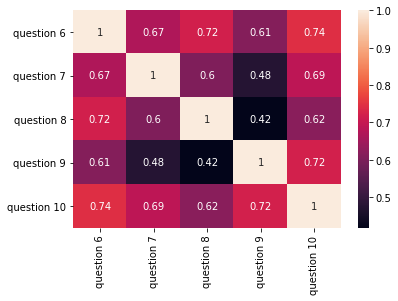

In [22]:
import seaborn as sns

df_lime = df[[f'question {6}', f'question {7}',f'question {8}',f'question {9}',f'question {10}']]

correlation_mat = df_lime.corr()

sns.heatmap(correlation_mat, annot = True)

plt.show()


## Correlation between the 5 criteria results for SHAP-local

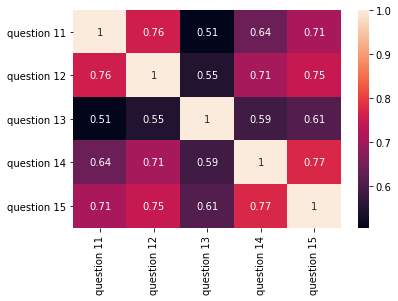

In [23]:
import seaborn as sns

df_lime = df[[f'question {11}', f'question {12}',f'question {13}',f'question {14}',f'question {15}']]

correlation_mat = df_lime.corr()

sns.heatmap(correlation_mat, annot = True)

plt.show()

## Correlation between the 5 criteria results for SHAP-global

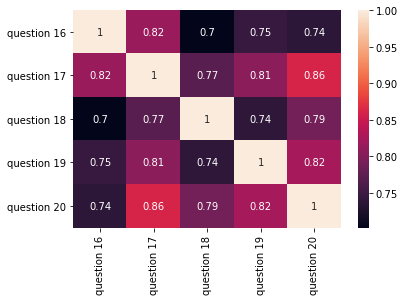

In [24]:
import seaborn as sns

df_lime = df[[f'question {16}', f'question {17}',f'question {18}',f'question {19}',f'question {20}']]

correlation_mat = df_lime.corr()

sns.heatmap(correlation_mat, annot = True)

plt.show()

## Correlation between the 5 criteria results for PDP

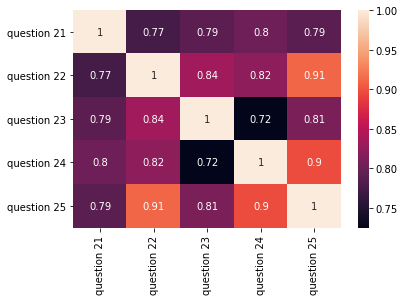

In [26]:
import seaborn as sns

df_lime = df[[f'question {21}', f'question {22}',f'question {23}',f'question {24}',f'question {25}']]

correlation_mat = df_lime.corr()

sns.heatmap(correlation_mat, annot = True)

plt.show()

The high correlation between the 5 criteria for each XAI method justifies the high correlation between the results for questions 3,4,6,7,8.